# DoWhy example on ihdp (Infant Health and Development Program) dataset

In [1]:
# importing required libraries
import dowhy
from dowhy import CausalModel
import pandas as pd
import numpy as np

### Loading Data

In [2]:
data= pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv", header = None)
col =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1" ,]
for i in range(1,26):
    col.append("x"+str(i))
data.columns = col
data = data.astype({"treatment":'bool'}, copy=False)
data.head()

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,True,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,False,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,False,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,False,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,False,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0


### 1.Model

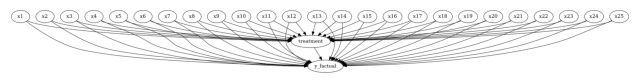

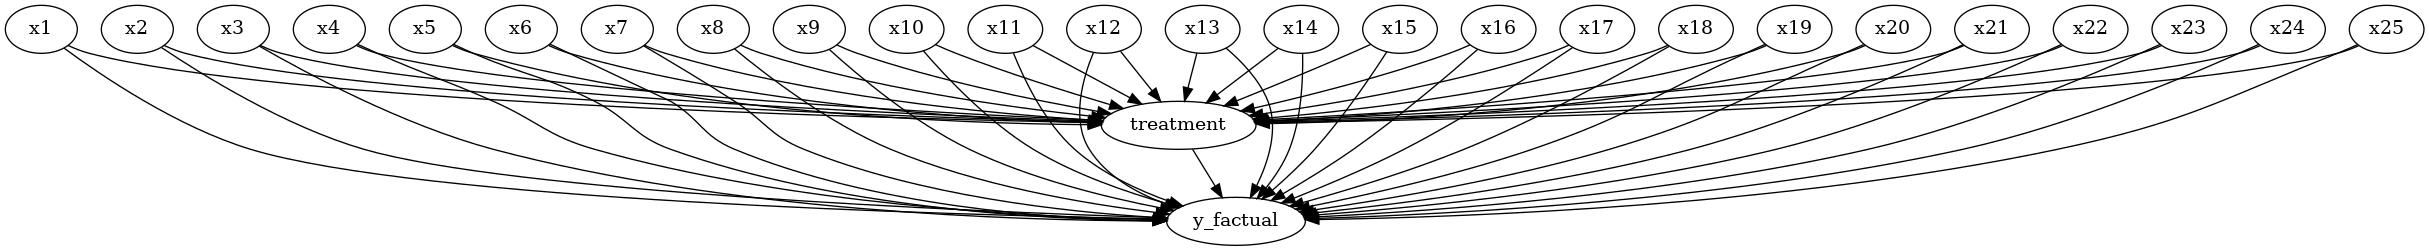

In [3]:
# Create a causal model from the data and given common causes.
model=CausalModel(
        data = data,
        treatment='treatment',
        outcome='y_factual',
        common_causes=["x"+str(i) for  i in range(1,26)]
        )
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

### 2.Identify

In [4]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True, method_name="maximal-adjustment")
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(E[y_factual|x1,x3,x24,x6,x13,x2,x21,x16,x20,x5,x22,x11,x17,x25,x1
d[treatment]                                                                  

                                       
2,x10,x14,x18,x9,x15,x8,x4,x23,x7,x19])
                                       
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→y_factual then P(y_factual|treatment,x1,x3,x24,x6,x13,x2,x21,x16,x20,x5,x22,x11,x17,x25,x12,x10,x14,x18,x9,x15,x8,x4,x23,x7,x19,U) = P(y_factual|treatment,x1,x3,x24,x6,x13,x2,x21,x16,x20,x5,x22,x11,x17,x25,x12,x10,x14,x18,x9,x15,x8,x4,x23,x7,x19)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### 3. Estimate (using different methods)

#### 3.1 Using Linear Regression

In [5]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression", test_significance=True
)

print(estimate)

print("Causal Estimate is " + str(estimate.value))
data_1 = data[data["treatment"]==1]
data_0 = data[data["treatment"]==0]

print("ATE", np.mean(data_1["y_factual"])- np.mean(data_0["y_factual"]))


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(E[y_factual|x1,x3,x24,x6,x13,x2,x21,x16,x20,x5,x22,x11,x17,x25,x1
d[treatment]                                                                  

                                       
2,x10,x14,x18,x9,x15,x8,x4,x23,x7,x19])
                                       
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→y_factual then P(y_factual|treatment,x1,x3,x24,x6,x13,x2,x21,x16,x20,x5,x22,x11,x17,x25,x12,x10,x14,x18,x9,x15,x8,x4,x23,x7,x19,U) = P(y_factual|treatment,x1,x3,x24,x6,x13,x2,x21,x16,x20,x5,x22,x11,x17,x25,x12,x10,x14,x18,x9,x15,x8,x4,x23,x7,x19)

## Realized estimand
b: y_factual~treatment+x1+x3+x24+x6+x13+x2+x21+x16+x20+x5+x22+x11+x17+x25+x12+x10+x14+x18+x9+x15+x8+x4+x23+x7+x19
Target units: ate

## Estimate
Mean va

#### 3.2 Using Propensity Score Matching

In [6]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching"
)

print("Causal Estimate is " + str(estimate.value))

print("ATE", np.mean(data_1["y_factual"])- np.mean(data_0["y_factual"]))


Causal Estimate is 3.97913882321704


ATE 4.021121012430829


#### 3.3 Using Propensity Score Stratification

In [7]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification", method_params={'num_strata':50, 'clipping_threshold':5}
)

print("Causal Estimate is " + str(estimate.value))
print("ATE", np.mean(data_1["y_factual"])- np.mean(data_0["y_factual"]))



Causal Estimate is 3.4550471588628207
ATE 4.021121012430829


#### 3.4 Using Propensity Score Weighting

In [8]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting"
)

print("Causal Estimate is " + str(estimate.value))

print("ATE", np.mean(data_1["y_factual"])- np.mean(data_0["y_factual"]))


Causal Estimate is 4.028748218390073
ATE 4.021121012430829


### 4. Refute
##### Refute the obtained estimate using multiple robustness checks.
##### 4.1 Adding a random common cause

In [9]:
refute_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute_results)

Refute: Add a random common cause
Estimated effect:4.028748218390073
New effect:4.028748218390073
p value:1.0



##### 4.2 Using a placebo treatment

In [10]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:4.028748218390073
New effect:-0.5027137375175218
p value:0.02



#### 4.3 Data Subset Refuter

In [11]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

Refute: Use a subset of data
Estimated effect:4.028748218390073
New effect:4.029156982583574
p value:0.98

